# Project: Mental health in Switzerland

In this notebook, we describe the multiple steps of our preprocessing pipeline and the work done on the Twitter dataset to answer our research question.

### Overview:

<ol start="0">
  <li><b>Data Collection & Preliminary Analysis:</b> how we accessed the datasets and why we use them</li>
  <li><b>Data Treatment:</b> cleaning and NLP on the first dataset</li>
  <li><b>Datasets Description for Spinn3r:</b> a first look at the Spinn3r Dataset</li>
  <li><b>Dictionary Construction:</b> creation of the dictionary we are going to us on the datasets</li>
  <li><b>Dictionary Update:</b> updating the dictionnary with what we learned thanks to the dataset</li>
  <li><b>Analysis of First Dataset:</b> anaysis of the smaller Spinn3r set for a proof of concept</li>
  <li><b>Processing Pipeline on the Second Dataset:</b> apply what we learned on the previous dataset on the second one</li>
  <li><b>Analysis of the Second Dataset:</b> applying what we learned on the smaller dataset on the swisscom-twitter dataset</li>
  <li><b>Conclusion</b></li>
</ol>

We quickly import the libraries to be used later:

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import pyspark as ps
import matplotlib.pyplot as plt
import seaborn as sns

#Part 1
import json
from pandas.io.json import json_normalize

#Part 2
import re
import unicodedata

#Part 3
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, TweetTokenizer
from collections import Counter

## 0. Data Collection & Preliminary Analysis

We were provided two separate datasets containing Swiss tweets. They were formated differently and contained different fields. On top of this, while the first dataset contained data collected over multiple years (twitter-swisscom, refered to as second dataset), the other only covers a span of 10 months (Spinn3r, refered to as first dataset).


The complete twitter data for both datsets was collected from the cluster provided in the class.

An example dataset of (_**twitter-swisscom**_) was retrieved from a .zip file provided.

Our second dataset (_**Spinn3r**_), however, did not provide a specific example datset. As a standing we extracted the first JSON file to perform our analysis. To do this, we used the following comands after connecting to the cluster:

```bash
cluster$ hadoop fs -getmerge /datasets/swiss-tweet/harvest3r_twitter_data_01-01_0.json /buffer/example.json
local$ scp -r gaspar@iccluster060.iccluster.epfl.ch:/buffer/example.json <local-path>
```

### Preliminary analysis

The goal of our preliminary analysis was to decide which dataset would be more useful but also to familiarize ourselves with the chosen dataset in order to know if we need to adapt our research questions or enrich the dataset with external information in order to perform our analysis.

After the analysis (presented below), we decided to use **both datasets** for our project. While the twitter-swisscom contains more precise location information (longitude and latitude), the Spinn3r dataset contains a sentiment analysis field as well as a language field and has a lot less data. Thus, we decided to create our functions and methods using the smaller dataset (Spinn3r) and use it as a proof of concept before going on a larger scale and use the swisscom-twitter dataset to further our analysis.

This dataset has an elaborate description of each field available on the [spinn3r website](http://docs.spinn3r.com/?Example#content-schema). Given the amount of data present in the cluster, we only look at one day to perform our first analysis (we will later show how we scale our operations using Spark).

This dataset is given in JSON format and has nested elements. As the *read_json* function does not work well with nested JSON data, we use a JSON normalizer, which is provided in the *Pandas.io* libary. 

_Note: We will later see that Spark deals better with nested JSON._

The fields found in this dataset are:

In [2]:
EXAMPLE_PATH = 'swiss-tweet/example.json'

with open(EXAMPLE_PATH) as data_file:    
    data = json.load(data_file)

twitter_df = json_normalize(data)
#rename columns for convenience
twitter_df.columns = [column.replace('_source.','') for column in twitter_df.columns]
twitter_df.columns

Index(['_id', '_index', '_score', 'author_avatar_img', 'author_gender',
       'author_link', 'author_name', 'bucket', 'canonical', 'date_found',
       'domain', 'hashcode', 'index_method', 'lang', 'links', 'main',
       'main_checksum', 'main_format', 'main_length', 'mentions', 'permalink',
       'published', 'resource', 'sentiment', 'sequence', 'sequence_range',
       'site', 'source_content_checksum', 'source_content_length',
       'source_created', 'source_date_found', 'source_description',
       'source_favicon_height', 'source_favicon_width', 'source_favorites',
       'source_followers', 'source_following', 'source_handle',
       'source_hashcode', 'source_http_status', 'source_image_height',
       'source_image_src', 'source_image_width', 'source_last_posted',
       'source_last_published', 'source_last_updated', 'source_likes',
       'source_link', 'source_location', 'source_parsed_posts',
       'source_parsed_posts_max', 'source_profiles', 'source_publisher_type',


Out of all these columns, we find the ones below to be the most useful for our analysis:
- **main**: contains the content of the tweet.
- **published**: gives the time on which the content was posted.
- **source_spam_probability**: probability of tweet being spam.
- **source_location**: location of the tweet.
- **tags**: tags associated with the tweet (provided by Spinn3r).
- **lang**: language of the tweet.
- **sentiment**: sentiment score of the tweet -POSITIVE, NEGATIVE, NEUTRAL-.
- **author_gender**: gender of the author -MALE, FEMALE, UNKNOWN-.
- **source_followers**: followers of the user who tweeted.
- **source_following**: number of people the user follows.

We consider these tags to be the most useful as:

- **Main** stands at the center of our analysis. We plan to perform NLP methods in order to identify relevant tweets and use the content as well to identify related words.
- **Published** can be used to map the tweets over the duration of the year and look for seasonal changes.
- **Source_location** can be used to look at the geographical distribution of the tweets.
- **Lang** will be used to filter out unwanted languages, which we need to do in order to perform our NLP tasks.
- **Author_gender** will be used to identify the gender and look at the differences between both gend

_Note:_ that on the cluster we find additional fields, out of which we decide to use **'author_user_id'**, as means to uniquely identify an user and **'geo_point'**, containing latitude and longitude, as a way to identify user location.

In [3]:
columns = ['main', 'published', 'source_spam_probability', 'source_location', 'tags', 'lang', 'sentiment',
                   'author_gender', 'source_followers', 'source_following']
twitter_df = twitter_df[columns]

#### Initial analysis of categorical data

We now give a quick look into data contained in the example dataset, to find how we need to clean it.

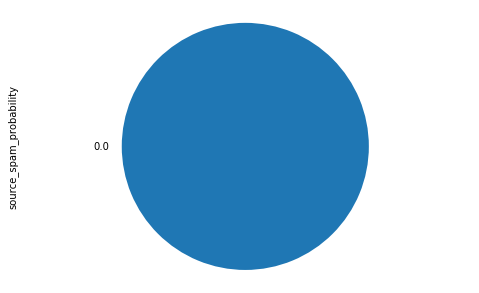

In [4]:
plt.figure(figsize=[8, 5])
twitter_df['source_spam_probability'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.show()

Looking at the spam probability of the tweet set, we see that not a single tweet was labeled as spam. This makes us question the accuracy of the labeling as the set of tweets on that day most certainly contains spam. However, we will still use it as we assume the chance of having false positives to be very low.

In [5]:
twitter_df[twitter_df.lang.isin(['de', 'fr', 'en'])]['source_location'].value_counts().tail(20)

Affoltern am Albis    1
สวิตเซอร์แลนด์        1
Schwyz                1
Suica                 1
Pfäffikon             1
Laufen                1
Sursee                1
Lauterbrunnen         1
Langnau               1
Conthey               1
Suíça                 1
Poschiavo             1
Andelfingen           1
Zofingen              1
Rheinfelden           1
Le Locle              1
Herisau               1
Meilen                1
İsviçre               1
Payerne               1
Name: source_location, dtype: int64

As the location seems to be language dependent, we only care about tweets written in the 3 languages we need. We see that:
- A lot of locations only differ in language (e.g. as Switzerland and Schweiz)
- The name of the locations are not always given languages we are interested in (e.g. สวิตเซอร์แลนด์)
- A vast majority of the dataset is just located in 'Switzerland'
- As opposed to dataset 1, all tweets are located in Switzerland

In [6]:
twitter_df.count()

main                       21795
published                  21795
source_spam_probability    21795
source_location            21795
tags                        3865
lang                       21795
sentiment                  20902
author_gender              21795
source_followers           21795
source_following           21795
dtype: int64

Looking at the missing values in the dataset, we see that for most tweets, the tags are missing. This may indicate that the tags won't be usefull for our analysis, but this does not influence our research at this stage.

We also note that for some tweets, the sentiment is missing. As noted on Spinn3er, this may be due to the fact that some tweets do not contain enough linguistic information. As we will filter out such tweets, the remaining set should contain sentiment. Even if doesn't, this field is not central to our analysis, it is merely used to help us filter our dataset.

### Identifying potential issues

While this set of tweets is not representative, we can still use it to find potential issues we might have with the tweets' content:

In [7]:
pd.set_option('display.max_colwidth', 200)
twitter_df.sample(n=10)['main']

8356              RT ""Terapeuta em Sete Lagoas, tratamento da Depressao , Panico, Ansiedade http://psicologosetelagoas.com.br  PSI000043""
16927                                             @iKabirBedi wishing you a very happy new year :) hope many dreams of yours will come true
14200                                                                                                 @AddictOfBieber_ c'est mieux comme ça
15244    @FwugRadiation Take all the time you need, man. I'll try to forget the hype as good as I can and continue my own fanart stuff <w<;
21267                                                               Happy New Year @robinrimbaud, wishing you a healthy and successful 2016
15369                                     @OneDrecti0nFans I don't look any better when I'm drunk, calm down guys I'm sure verything's okay
8713          RT "Psicologa em Curvelo, terapeuta de depressao, doenca do panico, adolescentes http://psicologosetelagoas.com.br  PSI00158"
1526                

Looking at the sample, we immediatly see that the tweets containing links are not relevant to our research question (they are mostly news or adds).

In [8]:
twitter_df.main[twitter_df.main.map(lambda x: 'http://' in x)].head(10)

6      Alpinultras. Sello, circuito y estudio médico para potenciar las travesías de ultrafondo de al… http://wp.me/p9GIl-b3O  vía @CarrerasMontana
7                                                                                   5 people unfollowed me today tracked by http://unfollowspy.com 
9                                                                           Wir wünschen euch von Herzen ein gesundes 2016! http://fb.me/7SfcGRpCP 
17                                                                                           Aktuellste Stellenangebote http://tinyurl.com/bugpgs8 
23        Naa geierst Du wieder und willst wichsen..Na gut aber Du musst 2 mal spritzen.Du musst… http://dlvr.it/D8jjgL  pic.twitter.com/LBV2QcdDIF
25                                                                                         AZEALIA BANKS - 212 FT. LAZY JAY http://fb.me/3GqunbPRp 
26           Alles Gute fürs Neue Jahr! Sehen Sie eine Videobotschaft des CEO #Bringhen Group: https://vimeo.com

Looking more intently at the tweets containing links, we can make the assumption that the relationship between URLs and spam is a general rule (at any time of the year).

Perform a vastly simplified version of the dictionary matching we will preform to get relevant tweets and analyze the results.

Here we look at the occurence of 'suicide' in the tweets:

In [9]:
pd.set_option('display.max_colwidth', 100)
twitter_df[twitter_df['main'].map(lambda x: 'suicide' in x) ]['main']

1731     Suicide bombing kills 1 at Kabul restaurant - http://news.bridgeward.com/suicide-bombing-kills-1...
3624                                              IS suicide attack planned in Munich http://bit.ly/1Owgpls 
5228     Afghanistan: attentat suicide dans un restaurant français de Kaboul - Europe1 http://dlvr.it/D8q...
6896     Ian Murdock's last night alive #debian http://sanfrancisco.cbslocal.com/2015/12/31/prominent-pro...
9479     Ipad Music Making Daily is out! http://paper.li/suicidesurfer77/1315555100?edition_id=bb78ee60-b...
10145     L'Etat islamique soupçonné d'avoir planifié un attentat suicide en Allemagne http://rss.ch/662786 
10446                           Afghanistan: attentat suicide dans le centre de Kaboul http://rss.ch/662843 
11096    Kaboul : les talibans revendiquent l'attentat suicide de ce 1er janvier contre un restaurant fra...
11377     L'Etat islamique soupçonné d'avoir planifié un attentat suicide en Allemagne http://rss.ch/662783 
14771              

By performing a simplistic dictionary matching using the occurences of the word *'suicide'* in our tweet set, we see that a lot of these tweets contain news. This further comforts us in our choice to remove tweets with URLs in order to get better results.

In [10]:
twitter_df[twitter_df['main'].map(lambda x: 'therapie' in x) ]['main']

11567    #Arbeit #Jobs #CH Chefarzt Psychiatrie/Psychotherapie 100 (w/m): Herisau, Appenzell Ausserrhoden...
12508    Aktuelle Firmensuche "Physiotherapie Praxis Bücheli" Ostermundigen (BE) #Gesundheitsberatung #Su...
13610    Natürlich Gesund: Mistel und Myrrhe in der Phytotherapie http://pure-natur.blogspot.ch/2014/06/t...
13720    Aktuelle Suchabfrage "Kunsttherapie" auf @Help_ch #Kunsttherapie #Suchportal #Schweiz #Suche htt...
Name: main, dtype: object

Looking at the word *'therapy'* (in German), we can confirm once again the issue there is with URLs.

In [11]:
twitter_df[twitter_df['main'].map(lambda x: 'RT ' in x) ]['main'].head()

124     RT @TimeOutSwiss : Discover some of the best ski resorts in #Switzerland #Swissalps #SwissSki #s...
3472    RT @SkafarPierre: General differences in use of social media for health care #hcsm #digitial #so...
3697                           RT @Boehringer: We wish you a happy new year! #Hcsm #hcsmeu #socmed #newyear
3751    RT @Paul_Sonnier: Tech That Will Change Your Life in 2016 http://stfi.re/xzzdya  #IoT #Whealth #...
3786    touche.... https://twitter.com/JamesRobertWebb/status/682951862929080322 … And #SometimesWhenIFe...
Name: main, dtype: object

Finally, we look at the retweets to get an idea on how useful they could be. From what we see, and what others have seen [8], they are not.

## 1. Data Treatment

Now that we have done some data exploration, we have to clean our dataset to be able to use it correctly for our research.

First, we use Pandas locally on a small subset of the tweets to explore different cleaning methods and make sure the functions we chose work as expected. After proving that our concept works, we use Spark to scale up our operations and be able to perform them on all the files provided on the cluster.

### Tweet filtering

Given the context of our research, there are many useless tweets. 
- First, we would like to get rid of any tweets with a spam probability greater than 0.5 (an arbitrary value we found sound). 
- Finally, as we are focused on the Swiss population, we only keep tweets in the official languages (except for Italian as no one in our group speaks the language, meaning we won't be able to extract useful information) and in English (as most tweets in the dataset, and more generally on Twitter, are written in English)

In [12]:
spam_mask = (twitter_df['source_spam_probability'] >= 0.5)
twitter_df.drop(twitter_df[spam_mask].index, inplace=True)
twitter_df.reset_index(drop=True, inplace=True)

In [13]:
lang_mask = ~twitter_df.lang.isin(['de', 'en', 'fr'])
twitter_df.drop(twitter_df[lang_mask].index, inplace=True)
twitter_df.reset_index(drop=True, inplace=True)

### Text treatment

Now that we only have relevant tweets (following a mild cleaning), we need to work on the main subject of our analysis: the content of the tweets itself. This is necessary to ease the _3rd Part_ of our research (processing the text to find patterns using NLP, _Natural Language Processing_).

To make later temporal analysis easier we transform the column containing the dates into datetime format.

In [14]:
twitter_df['published'] = pd.to_datetime(twitter_df['published'])
twitter_df['published'].head()

0   2016-01-01 00:30:04
1   2016-01-01 12:12:33
2   2016-01-01 19:52:15
3   2016-01-01 11:58:03
4   2016-01-01 06:17:28
Name: published, dtype: datetime64[ns]

The first step of our treatment is to lower all the caracters (allows comparing the tweets without case-sensitive searches).

In [15]:
twitter_df['main'] = twitter_df['main'].str.lower()
twitter_df['main'].head()

0                                                 en espérant que 2016 soit meilleur que 2015 quand même
1                                               nice bmw ...he kills ant s!!! pic.twitter.com/5zt5v1mljk
2    @madmenna ich hab nichts dagegen, wenn mir andere beim saufen zuschauen, solange sie pro minute ...
3     happy new jear!!!! i am back from 2 weeks cuba! let s go into the 2016! pic.twitter.com/bu0lbpfql3
4    @megadriver16 bonne année à toi je prends beaucoup de plaisir à suivre tes vidéos je suis un gra...
Name: main, dtype: object

As we have seen in _Part 1_, URLs are highly linked to spam (except for URLs linking pictures to the tweet). As image processing is not in the scope of this project, we remove all "pic.twitter" URLS and mentions of the format "@user". After that, we remove all tweets containing a URL and retweets as they do not give us any information.

In [16]:
url_mask = twitter_df['main'].str.contains("www\S+") | twitter_df['main'].str.contains("http\S+")
twitter_df['main'] = twitter_df['main'].str.replace("pic.twitter\S+", '')
twitter_df.drop(twitter_df[url_mask].index, inplace=True)
twitter_df.reset_index(drop=True, inplace=True)
twitter_df['main'].head()

0                                                 en espérant que 2016 soit meilleur que 2015 quand même
1                                                                         nice bmw ...he kills ant s!!! 
2    @madmenna ich hab nichts dagegen, wenn mir andere beim saufen zuschauen, solange sie pro minute ...
3                               happy new jear!!!! i am back from 2 weeks cuba! let s go into the 2016! 
4    @megadriver16 bonne année à toi je prends beaucoup de plaisir à suivre tes vidéos je suis un gra...
Name: main, dtype: object

In [17]:
alphanum_filter = lambda data: re.sub(r'[^\w\s]', '', data)

In [18]:
twitter_df['main'] = twitter_df['main'].map(alphanum_filter)
twitter_df['main'] = twitter_df['main'].str.replace('_', '') #not removed by previous regex
twitter_df.main.head()

0                                                 en espérant que 2016 soit meilleur que 2015 quand même
1                                                                               nice bmw he kills ant s 
2    madmenna ich hab nichts dagegen wenn mir andere beim saufen zuschauen solange sie pro minute 5 z...
3                                     happy new jear i am back from 2 weeks cuba let s go into the 2016 
4    megadriver16 bonne année à toi je prends beaucoup de plaisir à suivre tes vidéos je suis un gran...
Name: main, dtype: object

### Spark version

After performing all these cleaning steps, the size of the set is **significantly reduced** (the new file only weights **2.4MB** instead of the **55MB** of the original file, allowing us to reduce the set by **30x**). This is particularly helpful as the whole dataset represents around **30GB**.

_Note:_ the code was defined as _**Raw NBConvert**_ as it is not meant to be run on the notebook but on the cluster. The code is only here as information for the reader, it's executable can be found in the run.py file.

We start by importing the necessary elements and defining Spark environment variables.

We then import our data.

We filter tweets using the same method.

Text treatment is a little longer as it is more thorough in Spark.

Finally, we store the data in the _JSON_ we will be using.

## 2. Dataset Description for Spinn3r

We now preform a general analysis of the dataset on which we preform all the NLP methods and unsupervised clustering on.

We use a pkl file that was generated using *processing_pipeline.py* for speed an convenience.

In [19]:
twitter_df = pkl.load( open( "processed_tweets.pkl", "rb" ))

### General statistics:

We look at how many values we have for each field. The total number of tweets is $3936084$. We see that less than half of all tweets have a $geo\_point$ value associated to them

In [20]:
twitter_df.count()

author_gender              3936059
author_user_id             3022512
geo_point                  1209109
lang                       3936084
main                       3936084
published                  3936084
sentiment                  3936084
source_followers           3936084
source_following           3936084
source_location            3817038
source_spam_probability    3936084
tags                        638220
cleaned                    3936084
tokenized                  3936084
dtype: int64

### Distribution of categorical data

We now look at the distribution of categorical features in our dataset.

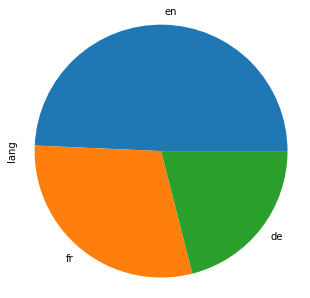

In [21]:
plt.figure(figsize=[5, 5])
twitter_df['lang'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.show()

We see that almost half of all tweets are in english, followed by french and german. The latter is interessting as given the swiss population, one would expect there to be more german than french tweets.

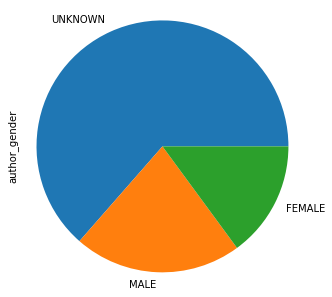

In [22]:
plt.figure(figsize=[5, 5])
twitter_df['author_gender'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.show()

We see that most accounts do not contain information on the user's gender (meaning there is no way we can have an unbiased set). However, the dataset still contains over a third of profiles where the gender is documented meaning we could use these to look at the differences in mental distress between the genders. Also note that male and female are not equaly represented in the dataset.

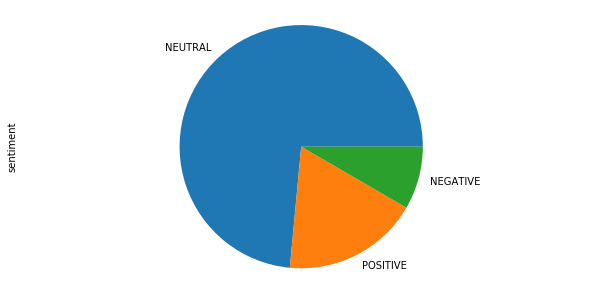

In [23]:
plt.figure(figsize=[10, 5])
twitter_df['sentiment'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.show()

Looking at the sentiment, we see that about three-quaters of all tweets are labeled as being neutral.

### Distribution of temporal data

we now look at the temporal distribution of the data. We look at daily and yearly patterns.

In [24]:
#Declaring functions
def get_time_distribution(times):
    publishing_time = times.map(lambda x: x.hour).value_counts()
    publishing_time.sort_index(inplace=True)
    return publishing_time

def plot_daily(df):
    times = get_time_distribution(df['published'])
    return plt.plot(times)

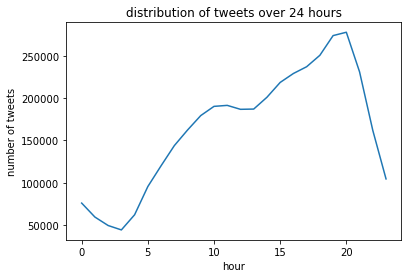

In [28]:
plot_daily(twitter_df)
plt.xlabel('hour')
plt.ylabel('number of tweets')
plt.title('distribution of tweets over 24 hours')
plt.show()

We see that the number of tweets is the largest around 8pm and rapidly decreases through the night, reaching its lowest point at around 3 in the morning. We can also observe a dip in the number of tweets during lunch time.

In [26]:
yearly_distribution = twitter_df.published.map(lambda x: x.month).value_counts()

/Users/lguillain/anaconda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


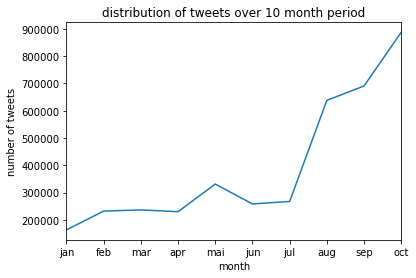

In [29]:
sns.tsplot(data=yearly_distribution, time=yearly_distribution.index)
plt.ylabel('number of tweets')
plt.title('distribution of tweets over 10 month period')
plt.xticks(range(1, 11),['jan', 'feb', 'mar', 'apr', 'mai', 'jun', 'jul', 'aug', 'sep', 'oct'])
plt.xlabel('month')
plt.show()

looking at the yearly distribution we see that the dataset is not balanced. It is possible that some of this inbalance is due to the number of twitter users and thus tweets rappidly increasing over a 10 month period. It may also be linked with the way Spinn3r retrived data from the set.

### Distribution of location data

We previously noted that only about 40% of all tweets have geo-location attached. We still look at how they are distributed over all. We note that we can find some points that are not in Switzerland. We do not filter out these tweets as we take the dataset as correct.

We use the tutoral by http://andrewgaidus.com/leaflet_webmaps_python/ to create this map. We use the geodata provided by https://github.com/ernstbaslerpartner/Switzerland_Tilemap.


In [34]:
#putting this here for convenience

import geopandas as gpd
from geopandas.tools import sjoin
import folium
from folium.plugins import MarkerCluster
#from folium.element import IFrame
import shapely
from shapely.geometry import Point
import pysal as ps

In [35]:
def process_location_data(df):
    """preprocessed data in format as found on cluster:
    df: dataframe, locations should be in 'geo_point'
    """
    non_null = df[~df.geo_point.isnull()]
    virgule = non_null[non_null.geo_point.str.contains(',')].geo_point.str.split(pat=',', expand=True).applymap(float)
    no_virgule = non_null[~non_null.geo_point.str.contains(',')].geo_point.str.split(expand=True).applymap(float)
    return pd.concat([virgule, no_virgule])

In [36]:
locations = process_location_data(twitter_df)

In [38]:
locations.head()

,0,1
59934,47.27232,8.64617
59935,47.51667,9.43333
59937,46.20222,6.14569
59938,47.55776,8.89893
59939,47.34999,7.90329


In [175]:
#transfrom to geoseries, use the correct format
location_geo = gpd.GeoSeries(locations.apply(lambda z: Point(z[1], z[0]), 1),crs={'init': 'epsg:4326'})

In [176]:
location_geo.head()

59934    POINT (8.64617 47.27232)
59935    POINT (9.43333 47.51667)
59937    POINT (6.14569 46.20222)
59938    POINT (8.89893 47.55776)
59939    POINT (7.90329 47.34999)
dtype: object

In [168]:
location = gpd.GeoDataFrame(twitter_df[~twitter_df.geo_point.isnull()], geometry=location_geo)

In [156]:
tracts = gpd.read_file('mygeodata/ch-cantons.topojson.shp')

In [169]:
tracts.head()

,id,name,geometry
index_right,,,
0,ZH,Zürich,"POLYGON ((8.807614761476149 47.22089128912891, 8.792644464446445 47.22288148814881, 8.7409288928..."
1,BE,Bern/Berne,"(POLYGON ((7.824565256525654 47.2658697869787, 7.824565256525654 47.26487468746875, 7.8277407740..."
2,LU,Luzern,"POLYGON ((8.048666066606661 46.78782398239824, 8.046851485148515 46.78682888288829, 8.0386858685..."
3,UR,Uri,"POLYGON ((8.934635463546355 46.91997319731973, 8.942801080108012 46.90982318231823, 8.9437083708..."
4,SZ,Schwyz,"POLYGON ((8.568997299729974 46.98982918291829, 8.54268586858686 46.97987818781878, 8.51864266426..."


In [178]:
location.head()

,author_gender,author_user_id,geo_point,lang,main,published,sentiment,source_followers,source_following,source_location,source_spam_probability,tags,cleaned,tokenized,geometry
50810,MALE,3.032828e+09,47.45152 8.58491,en,welcome #cs100 #swiss #bombardier #zrh,2016-07-01 15:47:58,POSITIVE,39,66,Sissach,0,"[Bombardier, CS100, Swiss, ZRH]",welcome cs100 swiss bombardier zrh,"[welcom, cs100, swiss, bombardi, zrh]",POINT (8.584910000000001 47.45152)
50812,UNKNOWN,3.520307e+07,47.55776 8.89893,en,survived the dentist!,2016-07-01 06:42:11,NEUTRAL,235,335,Winterthur,0,NaN,survived the dentist,"[surviv, dentist]",POINT (8.89893 47.55776)
50816,UNKNOWN,4.117696e+08,47.55839 7.57327,en,"@hashtagbandit_ @metmuseum @wethinkahead thank you, merci, danke ️",2016-07-01 20:47:01,POSITIVE,320,297,Basel,0,NaN,thank you merci danke,"[thank, merci, dank]",POINT (7.57327 47.55839)
50819,UNKNOWN,1.464643e+08,46.38318 6.23955,en,@mopkins15 tweet of the night!,2016-07-01 06:43:33,NEUTRAL,92,468,Lausanne,0,NaN,tweet of the night,"[tweet, night]",POINT (6.23955 46.38318)
50820,MALE,1.722705e+07,47.36667 8.55,en,@juristr @code uh. time to give it another try...,2016-07-01 12:44:05,NEUTRAL,1027,646,Zürich,0,NaN,uh time to give it another try,"[uh, time, give, anoth, tri]",POINT (8.550000000000001 47.36667)


In [191]:
tract_counts = gpd.tools.sjoin(location, tracts).groupby('id').size()

In [225]:
tracts.set_index('id', inplace=True)

In [226]:
tracts['counts'] = tract_counts

In [230]:
tracts.reset_index(inplace=True)

In [234]:
tract_counts

id
AG     73179
AI       176
AR      1695
BE     77966
BL      5583
BS     55803
FR      8931
GE    381266
GL       137
GR      9489
JU      2382
LU     18273
NE     11347
NW      1018
OW       794
SG     15590
SH       718
SO      6267
SZ      3712
TG      4706
TI     17052
UR       956
VD    124816
VS     34016
ZG      6438
ZH    338590
dtype: int64

In [274]:
SWISS_COORD = [46.85, 8.23] #location of switzerland
swiss_map = folium.Map(location = SWISS_COORD, zoom_start = 8, tiles = 'cartodbpositron')

In [275]:
swiss_map.choropleth(tracts.to_json(), data = tracts, key_on = 'feature.properties.{}'.format('id'),
                columns = ['id', 'counts'], fill_color = 'YlOrRd', threshold_scale=[1000, 10000, 20000, 30000, 40000])

In [276]:
swiss_map

We see that the tweets are concentrated in urban centers.
#it'd be nice to have a more finely grained map

### Natural Language Processing

Using NLP _(Natural Language Processing)_ is necessary given the nature of our dataset: tweets. Following the steps used in previous courses and in the papers we read, we came up with the following pipeline in order to process the tweets (and dictionary). The actualy pipeline is realized in the *processing_pipeline.py* script, as the pipeline takes about 5 mintes to run on our set of tweets. We here explain it's functionality.

_Note: we use nltk, a goto python NLP library which was very interesting for us as it offered operations in the various languages we are working on._

#### Helper functions
(cf. _Next part_ below for information)

#### Tweet formatting

NLP is mainly based on treating the data to obtain an adequate format to work with following 3 steps:
- Tokenizing: separating words, we use a special tweettokenizer to work onthe tweets
- Stop-words removal
- Stemming: keeping only the radical of a word (allows better comparison)

## 3. Dictionary Construction

###  Building the dictionary

The first step of building our dictionary was doing research on previous dictionaries that were used for similar problems, such as can be seen in [2], [3]. Starting from this, we built our own English dictionary _($4^{th}$ reference in the Bibliography at the end of the file)_ and carefully translated it in French and German.

_Note_: a more complete explanation of our dictionary construction is included in our report.

In [ ]:
DICT_PATH = "dictionary.csv"
dictionaries = pd.read_csv(DICT_PATH)
dictionaries.head()

In [ ]:
en_dict = dictionaries['english'].dropna()
fr_dict = dictionaries['french'].dropna()
de_dict = pd.concat([dictionaries['german'].dropna(), dictionaries['swiss_german'].dropna()])

After fetching our 3 datasets, we clean them as we did for the tweets in _Part 2_.

In [ ]:
en_dict = en_dict.map(lambda x: tknzr.tokenize(x))
fr_dict = fr_dict.map(lambda x: tknzr.tokenize(x))
de_dict = de_dict.map(lambda x: tknzr.tokenize(x))

### Processing the dictionary

Once we have our (clean) data, we simply run all the previous NLP methods on our dictionaries. 

_Note_: Special methods were written for the dictionaries as they do not follow the same format as tweets, but they are the same in essence.

In [ ]:
def dict_cleaning(lang):
    lang_dict = eval(lang + '_dict')
    lang_dict = lang_dict.astype(str).str.lower()

def dict_remove_stops(language):
    lang = language[:2]
    if language == 'german':
        lang = 'de'

    lang_dict = eval(lang + '_dict')
    lang_set = stopwords.words(language)
    lang_dict = lang_dict.apply(lambda expression: [word for word in expression if word not in lang_set])

def dict_stem_words(language):
    lang = language[:2]
    if language == 'german':
        lang = 'de'

    lang_dict = eval(lang + '_dict')
    stemmer = SnowballStemmer(language)

    lang_dict = lang_dict.apply(lambda expression: [stemmer.stem(word) for word in expression])

In [ ]:
dict_remove_stops('english')
dict_remove_stops('french')
dict_remove_stops('german')

In [ ]:
dict_stem_words('english')
dict_stem_words('french')
dict_stem_words('german')

To show the soundness of our method, we display the head of each dictionary:

In [ ]:
en_dict.head()

In [ ]:
fr_dict.head()

In [ ]:
de_dict.head()

### Dictionary evaluation

In this part, we cross the dataset with our dictionaries to retrieve the tweets exhibiting mental distress. This is the first (less naive) step of our analysis before using Topic Modeling methods on our data.

We now check if we can find a dict entry for each tweet, by using the following algorithm, that checks if a keyword occurs at least once in the tweets.

In [ ]:
def compare(s, t):
    """compares to lists, and returns 
    true for all possible permutations of same list
    s, t: lists to compare
    """
    return Counter(s) == Counter(t)

def match_dict(tweet, dict_):
    """returns keywords that match in string
    tweet: tweet to find keywords in
    dict_: list of keywords
    """
    doc = [sublist for sublist in dict_ if compare(list(filter(lambda x: x in tweet, sublist)), sublist) ]
    return doc#at least one match

This gives us the following results for each language.


For english:

In [ ]:
#import from keywordfile and show head

We can clearly see sadness an loneliness or fear in these tweets, but some of them do not actualy express distress.
We also note that the number of tweets has greatly been reduces through this.

Now we look at the French tweets and again find similar results:

In [ ]:
#import from keywordfile and show head

Finally, for German we get the following results:

In [ ]:
#import from keywordfile and show head

Not only do all of this tweets reference the person, but they also talk about sadness or dissapointment.
The remaining number is quite small, compared to the initial 4000 german tweets in the dataset, but it is a number we might expect.

Still those results could be better.

#### Building the LDA

#### Evaluation of the sample

## 4. Dictionary Update

## 5. Analysis of First Dataset

#### Mapping from Dataset 1 to Dataset 2

Formatting is as follows: **Column in Dataset 2** -> Column in Dataset 1

- **author_user_id**           -> userId
- **geo_point**                -> longitude + latitude (or: placeLongitude + placeLatitude)
- **main**                     -> text
- **published**                -> createdAt
- **source_followers**         -> followersCount
- **source_following**         -> friendsCount (or is it folowwers that are following ?)
- **source_location**          -> userLocation


#### Dataset 1 having no equivalent : 
- id                                -> tweet ID
- truncated                         -> no idea, only NaNs
- placeId                           -> ID of where they are
- inReplyTo                         -> If it is a tweet reply
- source & sourceName, sourceUrl    -> what user used to send tweet (Android, website, and so on)
- userName                          -> username
- screenName                        -> name shown on tweets from username
- statusesCount                     -> number of status of user

#### Dataset 2 having no equivalent : 
- **author_gender**                 -> author's gender
- **lang**                          -> language of tweet (given)
- **sentiment**                     -> tweet's sentiment analysis (given)
- **source_spam_probability**       -> spam probability of tweet (given)
- **tags**                          -> hashtags contained in the tweet (in Dataset 1 stays in text)
- **tokenized**                     -> tokenized text of tweet (done by us)
- **keywords**                      -> keywords fund in tweets (done by us)

## 6. Processing Pipeline on the Second Dataset

The dataset comes with a *txt schema*, giving us an idea of the meaning of each column in the *tsv file* containing the tweets. We were also given a sample file to get an overview of the data, but we also optained the complete set of tweets (5GB) in a _.zip_ file.

The dataset contains the following useful columns:

- **userId** : id identifying the user.
- **createdAt** : time the tweet was posted.
- **text** : content of the tweet.
- **placeLatitude** : latitude of the tweet.
- **placeLongitude** : longitude of the tweet.
- **sourceName** : username.
- **sourceUrl** : URL of the tweet.
- **followersCount** : number of followers.
- **friendsCount** : number of mutual follows.
- **statusesCount** : number of statuses of user.

The sample dataset contains a lot of NaN values, and each column contains at least 1% or more NaN values.

The complete analysis and code can be found in the [Basic Exploration dataset 1 notebook](Basic%20Exploration%20Dataset%201.ipynb)

## 7. Analysis of the Second Dataset

## 8. Conclusion